In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import string

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)

from sklearn.cluster import MiniBatchKMeans

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

RANDOM_STATE = 37
np.random.seed(RANDOM_STATE)

# Зниження розмірності і візуалізація даних


In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

df = pd.read_csv(
    data_url,
    header=None,
    names=column_names,
    na_values=[" ?", "?"],
    skipinitialspace=True
)

print("Початковий розмір:", df.shape)
print("Пропуски:\n", df.isna().sum())

df = df.dropna().reset_index(drop=True)
print("Після dropna:", df.shape)

X = df.drop("income", axis=1)
y = (df["income"].str.strip() == ">50K").astype(int)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Числові ознаки:", numeric_features)
print("Категоріальні ознаки:", categorical_features)

# OneHotEncoder з щільним виходом (для PCA)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Початковий розмір: (32561, 15)
Пропуски:
 age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64
Після dropna: (30162, 15)
Числові ознаки: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Категоріальні ознаки: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Train shape: (24129, 14) Test shape: (6033, 14)


Базовий RandomForest без PCA

=== RandomForest без PCA ===
Час навчання: 21.66 c
Accuracy: 0.8533068125310791
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4531
           1       0.75      0.62      0.68      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.78      0.79      6033
weighted avg       0.85      0.85      0.85      6033



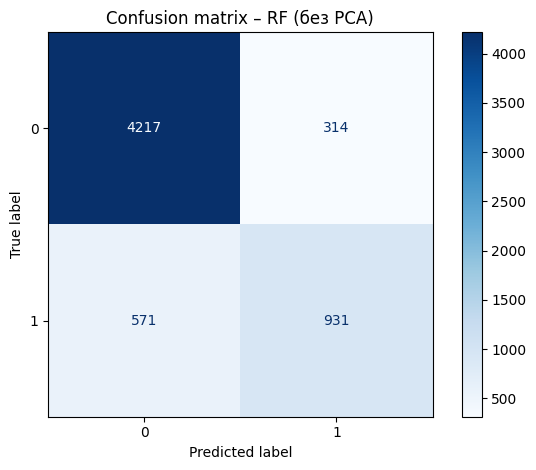

In [3]:
rf_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

start_time = time.time()
rf_base.fit(X_train, y_train)
train_time_base = time.time() - start_time

y_pred_base = rf_base.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)

print("=== RandomForest без PCA ===")
print("Час навчання: %.2f c" % train_time_base)
print("Accuracy:", acc_base)
print(classification_report(y_test, y_pred_base))

cm_base = confusion_matrix(y_test, y_pred_base)
ConfusionMatrixDisplay(cm_base).plot(cmap="Blues")
plt.title("Confusion matrix – RF (без PCA)")
plt.tight_layout()
plt.show()

Модель RandomForest без PCA показує загальну точність близько 85% при часі навчання 21.7 с, що для цього датасета є прийнятним базовим рівнем. Weighted-середні precision, recall та f1-score також ≈0.85, тобто якість досить збалансована, а більшість об’єктів класифікуються правильно; це видно з матриці де з 6033 прикладів 4217 + 931 = 5148 класифіковано вірно. Для класу 0 (низький дохід) precision 0.88, recall 0.93, f1 0.91, модель добре розпізнає більшість класу 0 і рідко помилково відносить його до класу 1 (FP = 314). Для класу 1 (високий дохід) якість нижча: precision 0.75, recall 0.62, f1 0.68, тобто з 1502 =>50 прикладів лише 931 визначено правильно, а 571 випадок модель помилково відносить до класу 0.

RandomForest + PCA

=== RandomForest + PCA (69 компонент) ===
Час навчання: 62.28 c
Accuracy: 0.8410409414884801
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4531
           1       0.73      0.58      0.65      1502

    accuracy                           0.84      6033
   macro avg       0.80      0.75      0.77      6033
weighted avg       0.83      0.84      0.83      6033



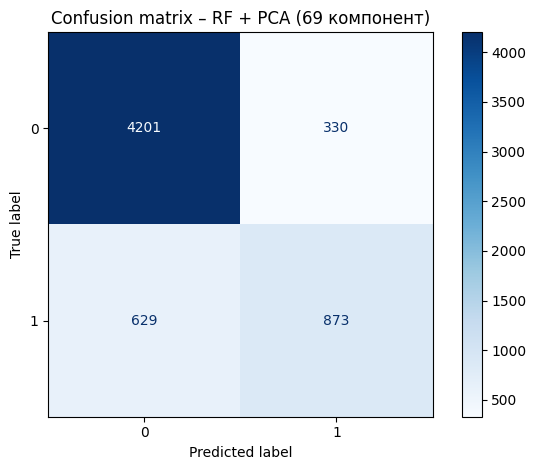

Порівняння:
Без PCA: accuracy = 0.8533, час = 21.66 c
З  PCA: accuracy = 0.8410, час = 62.28 c


In [4]:
pca_components = 69  # фіксоване число компонент для прикладу

rf_pca = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=pca_components, random_state=RANDOM_STATE)),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

start_time = time.time()
rf_pca.fit(X_train, y_train)
train_time_pca = time.time() - start_time

y_pred_pca = rf_pca.predict(X_test)
acc_pca = accuracy_score(y_test, y_pred_pca)

print("=== RandomForest + PCA (%d компонент) ===" % pca_components)
print("Час навчання: %.2f c" % train_time_pca)
print("Accuracy:", acc_pca)
print(classification_report(y_test, y_pred_pca))

cm_pca = confusion_matrix(y_test, y_pred_pca)
ConfusionMatrixDisplay(cm_pca).plot(cmap="Blues")
plt.title(f"Confusion matrix – RF + PCA ({pca_components} компонент)")
plt.tight_layout()
plt.show()

print("Порівняння:")
print("Без PCA: accuracy = %.4f, час = %.2f c" % (acc_base, train_time_base))
print("З  PCA: accuracy = %.4f, час = %.2f c" % (acc_pca, train_time_pca))

RandomForest з PCA на 69 компонент дає гірші результати, ніж базова модель: accuracy падає з 0.8533 до 0.8410, macro f1 з 0.79 до 0.77, а weighted f1 з 0.85 до 0.83. Час навчання при цьому збільшується майже утричі: з 21.7 с до 62.3 с, тобто зменшення розмірності в такій конфігурації не пришвидшило, а навпаки ускладнило навчання через додатковий крок PCA і роботу з щільною матрицею ознак.

t-SNE до 2D для візуалізації

Shape після препроцесингу: (1500, 95)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


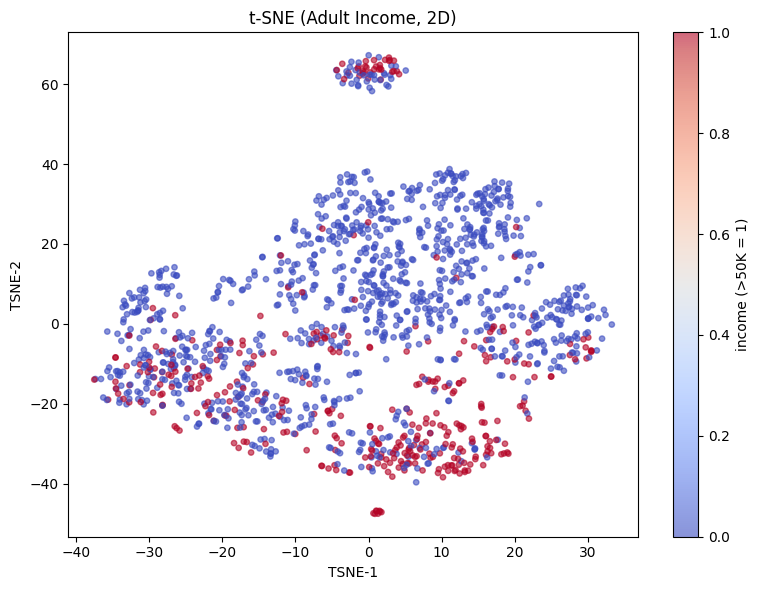

In [5]:
sample_size = 1500

X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=sample_size,
    random_state=RANDOM_STATE,
    stratify=y
)

X_sample_proc = preprocessor.fit_transform(X_sample)
print("Shape після препроцесингу:", X_sample_proc.shape)

tsne = TSNE(
    n_components=2,
    perplexity=40,
    n_iter=1000,
    random_state=RANDOM_STATE,
    init="random",
    learning_rate="auto"
)

X_tsne = tsne.fit_transform(X_sample_proc)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y_sample,
    cmap="coolwarm",
    alpha=0.6,
    s=15
)
plt.title("t-SNE (Adult Income, 2D)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(scatter, label="income (>50K = 1)")
plt.tight_layout()
plt.show()


На t-SNE видно, що дані утворюють кілька щільних кластерів, структура простору ознак є складною й багатомодальною. Більша частина точок пофарбована в синій колір (клас доходу <=50K), що відображає дисбаланс класів. Є області, де майже всі точки сині, тобто локально там живе майже тільки клас 0, але чіткої глобальної межі між класами немає - кластери частково перекриваються. Червоні точки (дохід >50K) концентруються в кількох зонах (особливо в нижній частині проекції), але й там вони змішані з синіми, а частина червоних розкидана серед синіх кластерів. Це означає, що навіть у хорошій нелінійній 2D-візуалізації класи не розділяються повністю, тобто задача є помірно складною, бо існують локальні області, де клас 1 відносно чистий, але в цілому він сильно перекривається з класом 0.

# Кластерний аналіз

In [12]:
from google.colab import files
from matplotlib.image import imread

print("Завантажити зображення (.jpg)...")
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print("Файл:", image_path)

img = imread(image_path)

# Якщо RGBA — відкиється альфа-канал
if img.shape[-1] == 4:
    img = img[:, :, :3]

h, w, c = img.shape
print("Розмір зображення:", h, "x", w, "канали:", c)

pixels = img.reshape(-1, c).astype(np.float32)

Завантажити зображення (.jpg)...


Saving 1155px-Cole_Thomas_The_Course_of_Empire_The_Arcadian_or_Pastoral_State_1836.jpg to 1155px-Cole_Thomas_The_Course_of_Empire_The_Arcadian_or_Pastoral_State_1836 (1).jpg
Файл: 1155px-Cole_Thomas_The_Course_of_Empire_The_Arcadian_or_Pastoral_State_1836 (1).jpg
Розмір зображення: 720 x 1155 канали: 3


Функція квантування і візуалізація результатів

Запуск KMeans для k=64...
Запуск KMeans для k=32...
Запуск KMeans для k=16...
Запуск KMeans для k=8...


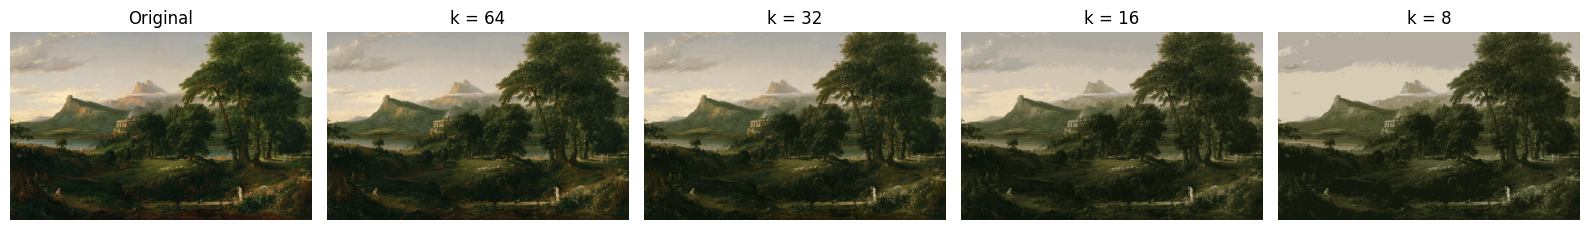

In [17]:
if img.max() > 1:
    img = img / 255.0

h, w, c = img.shape
# Перетворення в двовимірний масив (кількість пікселів, канали)
pixels = img.reshape(-1, c)

# KMeans
def quantize_standard(pixels, k):
    print(f"Запуск KMeans для k={k}...")
    # n_init=3 для пришвидшення (стандартно 10, що дуже довго)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
    labels = kmeans.fit_predict(pixels)
    new_colors = kmeans.cluster_centers_[labels]
    return new_colors.reshape(h, w, c)

# Візуалізація
ks = [64, 32, 16, 8]

fig, axes = plt.subplots(1, len(ks) + 1, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for ax, k in zip(axes[1:], ks):
    q_img = quantize_standard(pixels, k)
    ax.imshow(q_img)
    ax.set_title(f"k = {k}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Для k=64 зображення майже не відрізняється від оригіналу. При k=32 змін уже трохи більше, але деталізація і градієнти не сильно страждають, картинка візуально залишається природною, особливо на фоні й у рослинності. k=16 небо та схили стають пластами із близькими відтінками, але для задач стиснення це ще прийнятний компроміс. При k=8 ефект постеризації вже сильний: великі однорідні ділянки, грубі переходи, суттєва втрата глибини сцени. k=32 дає хороше співвідношення між якістю й зменшенням кількості кольорів

# Обробка та класифікація текстових даних

In [18]:
# Використаємо 2 класи з 20newsgroups: спорт (hockey) vs космос (space)

categories = ["rec.sport.hockey", "sci.space"]

newsgroups = fetch_20newsgroups(
    subset="all",
    categories=categories,
    remove=("headers", "footers", "quotes")
)

texts = newsgroups.data
labels = newsgroups.target
target_names = newsgroups.target_names

print("Класи:", target_names)
print("Кількість документів:", len(texts))

df_text = pd.DataFrame({
    "text": texts,
    "label": labels
})
df_text.head()


Класи: ['rec.sport.hockey', 'sci.space']
Кількість документів: 1986


,text,label
0,"\n\n\n\n\n\nWell, I guess I'm left wondering j...",1
1,"\n\n\n\n\tI think that you are incorrect, Roge...",0
2,"Forwarded from Neal Ausman, Galileo Mission Di...",1
3,\nPierre Turgeon of the Islanders,0
4,,0


Чистка тексту для WordCloud

In [19]:
def clean_text_for_wc(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.translate(str.maketrans("", "", string.digits))
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return " ".join(tokens)

df_text["clean_text"] = df_text["text"].apply(clean_text_for_wc)
df_text.head()

,text,label,clean_text
0,"\n\n\n\n\n\nWell, I guess I'm left wondering j...",1,guess left wondering just light fascists think...
1,"\n\n\n\n\tI think that you are incorrect, Roge...",0,think incorrect roger patrick smythe adams pla...
2,"Forwarded from Neal Ausman, Galileo Mission Di...",1,forwarded neal ausman galileo mission director...
3,\nPierre Turgeon of the Islanders,0,pierre turgeon islanders
4,,0,


WordCloud для кожного класу

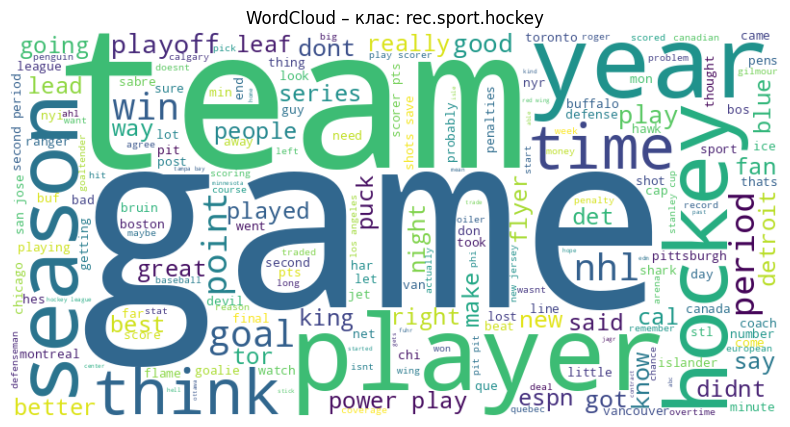

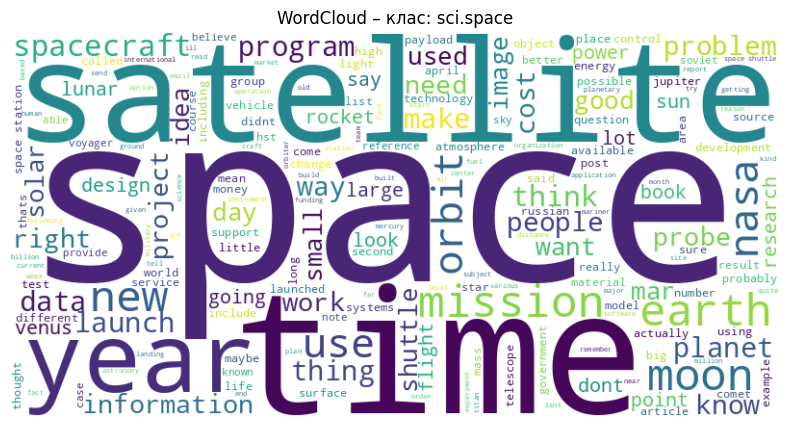

In [20]:
for class_id, class_name in enumerate(target_names):
    class_texts = df_text.loc[df_text["label"] == class_id, "clean_text"]
    full_text = " ".join(class_texts)

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=200
    ).generate(full_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – клас: {class_name}")
    plt.show()

У класі sci.space wordcloud показує домінування термінів, пов’язаних з космосом і технікою: space, satellite, orbit, тощо. У класі rec.sport.hockey частотні слова повністю інші: team, game, player, season, goal. Wordcloud показує тематичне розділення двох класів(космічна термінологія проти спортивної/хокейної), тексти добре придатні для задачі класифікації.

TF-IDF + LogisticRegression класифікація

TF-IDF shape: (1986, 6909)
=== Текстова класифікація (LogReg + TF-IDF) ===
Час навчання: 4.00 c
                  precision    recall  f1-score   support

rec.sport.hockey       1.00      0.91      0.95       200
       sci.space       0.91      1.00      0.95       198

        accuracy                           0.95       398
       macro avg       0.96      0.95      0.95       398
    weighted avg       0.96      0.95      0.95       398



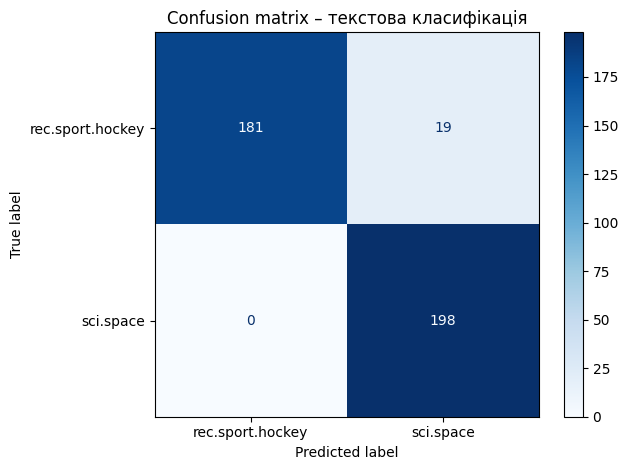

In [21]:
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df_text["text"])
y_text = df_text["label"].values

print("TF-IDF shape:", X_tfidf.shape)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tfidf, y_text,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_text
)

clf_text = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

start_time = time.time()
clf_text.fit(X_train_t, y_train_t)
train_time_text = time.time() - start_time

y_pred_t = clf_text.predict(X_test_t)

print("=== Текстова класифікація (LogReg + TF-IDF) ===")
print("Час навчання: %.2f c" % train_time_text)
print(classification_report(y_test_t, y_pred_t, target_names=target_names))

cm_text = confusion_matrix(y_test_t, y_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=target_names)
disp.plot(cmap="Blues")
plt.title("Confusion matrix – текстова класифікація")
plt.tight_layout()
plt.show()


Модель LogisticRegression на TF-IDF-ознаках дає дуже високу якість( загальна accuracy 0.95, macro й weighted f1 0.95). Для класу rec.sport.hockey precision = 1.00, recall = 0.91, тобто всі передбачені як hockey дійсно відносяться до цього класу, але 9% реальних хокейних текстів переплутані з space. Для sci.space ситуація така сама: precision = 0.91, зате recall = 1.00, тобто модель знаходить усі космічні тексти, але іноді приймає хокейні тексти за space. Простір TF-IDF (1986 документів, 6909 ознак) разом із чітко різною тематичною лексикою двох класів робить задачу добре роздільною, тому лінійний класифікатор працює ефективно і швидко (4 с на навчання)